# Head
*Imports and Functions*

In [205]:
#if necessary import the model data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import TruncatedSVD 
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest


import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential
from tensorflow import feature_column
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

#validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

In [168]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [169]:
# A utility method to create a feature column
# and to transform a batch of data
def demo(feature_column):
  feature_layer = layers.DenseFeatures(feature_column)
  print(feature_layer(example_batch).numpy())

In [170]:
#A summary of missing variables represented as a percentage of the total missing content. 
def null_summary(df, print_log=False, sort='ascending'):
    s = df.isnull().sum()*100/df.isnull().count()
    
    if sort.lower() == 'ascending':
        s = s.sort_values(ascending=True)
    elif sort.lower() == 'descending':
        s = s.sort_values(ascending=False)  
    if print_log: 
        print('Percentage of null values: \n', s)
  
    return pd.Series(s)

# Data Acquisition

In [171]:
#get the data
talkdata = pd.read_csv('/content/drive/MyDrive/Thinkful/Data/talkdata.csv')
#Quick look at the head.
talkdata.head()

,timestamp,longitude,latitude,coordinates,is_active,phone_brand,device_model,category,gender,age,group
0,2016-05-01 14:23:37,0.0,0.0,"(0.0, 0.0)",1.0,小米,MI 2,1 free,M,35,M32-38
1,2016-05-01 14:23:37,0.0,0.0,"(0.0, 0.0)",1.0,小米,MI 2,Cozy 1,M,35,M32-38
2,2016-05-01 14:23:37,0.0,0.0,"(0.0, 0.0)",1.0,小米,MI 2,Industry tag,M,35,M32-38
3,2016-05-01 14:23:37,0.0,0.0,"(0.0, 0.0)",1.0,小米,MI 2,Property Industry 2.0,M,35,M32-38
4,2016-05-01 14:23:37,0.0,0.0,"(0.0, 0.0)",1.0,小米,MI 2,music,M,35,M32-38


In [172]:
#The size and shape of this dataset before categorical changing.
talkdata.shape

(7832282, 11)

In [173]:
#Set the timestamp column to a datetime datatype.[Shame on me fo ridding myself of hte epoch timesetamp before I started the Deep learning]
talkdata['timestamp'] = pd.to_datetime(talkdata.timestamp)
talkdata.timestamp.dtype

#create the categorical time columns
talkdata['hour'] = talkdata.timestamp.dt.hour
talkdata['weekday'] = talkdata.timestamp.dt.dayofweek
#get the day of the week as an integer. 
talkdata['week'] = talkdata.timestamp.dt.isocalendar().week.astype(int)

talkdata.describe(include='all', datetime_is_numeric=True)

,timestamp,longitude,latitude,coordinates,is_active,phone_brand,device_model,category,gender,age,group,hour,weekday,week
count,7832282,7.832282e+06,7.832282e+06,7832282,7.832282e+06,7832282,7832282,7832282,7832282,7.832282e+06,7832282,7.832282e+06,7.832282e+06,7.832282e+06
unique,NaN,NaN,NaN,32921,NaN,89,926,441,2,NaN,12,NaN,NaN,NaN
top,NaN,NaN,NaN,"(0.0, 0.0)",NaN,华为,荣耀6,Industry tag,M,NaN,M39+,NaN,NaN,NaN
freq,NaN,NaN,NaN,2295988,NaN,2422726,354430,907153,5566437,NaN,1360719,NaN,NaN,NaN
mean,2016-05-04 13:58:30.355242240,7.837463e+01,2.182485e+01,NaN,3.404700e-01,NaN,NaN,NaN,NaN,3.350478e+01,NaN,1.306016e+01,2.963128e+00,1.786502e+01
min,2016-04-30 23:52:24,-1.800000e+02,-3.380000e+01,NaN,0.000000e+00,NaN,NaN,NaN,NaN,1.100000e+01,NaN,0.000000e+00,0.000000e+00,1.700000e+01
25%,2016-05-02 20:22:46.500000,0.000000e+00,0.000000e+00,NaN,0.000000e+00,NaN,NaN,NaN,NaN,2.700000e+01,NaN,8.000000e+00,1.000000e+00,1.800000e+01
50%,2016-05-04 14:05:48,1.127500e+02,2.857000e+01,NaN,0.000000e+00,NaN,NaN,NaN,NaN,3.100000e+01,NaN,1.300000e+01,3.000000e+00,1.800000e+01
75%,2016-05-06 08:22:22,1.171700e+02,3.401000e+01,NaN,1.000000e+00,NaN,NaN,NaN,NaN,3.900000e+01,NaN,1.900000e+01,5.000000e+00,1.800000e+01
max,2016-05-08 00:00:08,1.511800e+02,5.364000e+01,NaN,1.000000e+00,NaN,NaN,NaN,NaN,8.900000e+01,NaN,2.300000e+01,6.000000e+00,1.800000e+01


In [174]:
null_summary(talkdata)

timestamp       0.0
longitude       0.0
latitude        0.0
coordinates     0.0
is_active       0.0
phone_brand     0.0
device_model    0.0
category        0.0
gender          0.0
age             0.0
group           0.0
hour            0.0
weekday         0.0
week            0.0
dtype: float64

# Deep Learning - Gender

## Data Configuration

In [ ]:
#Change the target variable to numeric, zero will represent the male population.
talkdata['target'] = np.where(talkdata.gender == "M", 0, 1)

#This will get converted into a dataset later. 
X = talkdata.drop(columns=['hour', 'weekday', 'week', 'coordinates', 'gender', 'age', 'group'])
#We will be using tensorflow methods to work with the timestamp.
X['timestamp'] = talkdata['timestamp'].astype('int64')
X.shape

(7832282, 8)

In [ ]:
train, test = train_test_split(X, test_size=0.5)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

1566456 train examples
391614 validation examples
1958071 test examples


In [ ]:
train.shape

(1566456, 4)

In [ ]:
batch_size = 5 # A small batch sized is used for demonstration purposes
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

## Feature Engineering

In [ ]:
#Explore the dataset.
for feature_batch, label_batch in train_ds.take(1):
  print('Every feature:', list(feature_batch.keys()))
  print('A batch of ages:', feature_batch['phone_brand'])
  print('A batch of targets:', label_batch )

Every feature: ['timestamp', 'longitude', 'latitude', 'is_active', 'phone_brand', 'device_model', 'category']
A batch of ages: tf.Tensor(
[b'OPPO' b'\xe5\x8d\x8e\xe4\xb8\xba' b'\xe5\xb0\x8f\xe7\xb1\xb3'
 b'\xe5\x8d\x8e\xe4\xb8\xba' b'\xe9\xad\x85\xe6\x97\x8f'], shape=(5,), dtype=string)
A batch of targets: tf.Tensor([0 0 0 1 0], shape=(5,), dtype=int64)


In [ ]:
# Taking a look at feature columns
# We will use this batch to demonstrate several types of feature columns
example_batch = next(iter(train_ds))[0]

In [ ]:
feature_columns = []

In [ ]:
#Bucketizing these categorical columns that have fewer than 30 features.
is_active = feature_column.numeric_column('is_active')
is_active_buckets = feature_column.bucketized_column(is_active, boundaries=[0.])
feature_columns.append(is_active_buckets)

In [ ]:
#Embedding column for my sparse categories. The dimension parameter must be tuned. 
time_cat = feature_column.categorical_column_with_vocabulary_list(
      'timestamp', X.timestamp.unique())
time_embedding = feature_column.embedding_column(time_cat, dimension=27)
feature_columns.append(time_embedding)

In [ ]:
#Crossed feature columns - phone_brand and device_model
device_crossed_feature = feature_column.crossed_column(['device_model', 'phone_brand'], hash_bucket_size=16)
demo(feature_column.indicator_column(device_crossed_feature))

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


In [ ]:
feature_columns.append(feature_column.indicator_column(device_crossed_feature))

In [ ]:
#Crossed feature columns - phone_brand and device_model
coordinates_crossed_feature = feature_column.crossed_column(['latitude', 'longitude'], hash_bucket_size=23)
demo(feature_column.indicator_column(coordinates_crossed_feature))

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [ ]:
feature_columns.append(feature_column.indicator_column(coordinates_crossed_feature))

In [ ]:
#Embedding column for my sparse categories. The dimension parameter must be tuned. 
category = feature_column.categorical_column_with_vocabulary_list(
      'category', X.category.unique())
cat_embedding = feature_column.embedding_column(category, dimension=10)
demo(cat_embedding)

[[-0.30284244  0.36342755  0.03773946 -0.22305723 -0.31661502  0.30962795
   0.37174764  0.13541049 -0.29160804  0.012848  ]
 [-0.04579981 -0.09806786  0.42160332 -0.5138263   0.3396256  -0.45532805
   0.47067556 -0.07336164 -0.5509242   0.1753399 ]
 [ 0.40636963  0.18860018  0.01013719 -0.35508063  0.40849215  0.13797355
  -0.5759244  -0.03705606 -0.14496075 -0.41067967]
 [ 0.0933668   0.17364979 -0.08213485  0.31882548  0.35428745 -0.07178674
  -0.429313    0.31991947 -0.11599248 -0.35484403]
 [ 0.40636963  0.18860018  0.01013719 -0.35508063  0.40849215  0.13797355
  -0.5759244  -0.03705606 -0.14496075 -0.41067967]]


In [ ]:
feature_columns.append(cat_embedding)

In [ ]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

## Gender Prediction

In [ ]:
batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [ ]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dropout(.1),
  layers.Dense(1)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=10)

Epoch 1/10
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
97904/97904 [==============================] - ETA: 0s - loss: 0.4891 - accuracy: 0.7595WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'timestamp': <tf.Tensor 'ExpandDims_6:0' shape=(None, 1) dtype=int64>, 'longitude': <tf.Tensor 'ExpandDims_4:0' shape=(None, 1) dtype=float64>, 'latitude': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=float64>, 'is_active': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=float64>, 'phone_brand': <tf.Tensor 'ExpandDims_5:0' shape=(None, 1) dtype=string>, 'device_model': <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=string>, 'category': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=string>}
Consider rewriting this model with the Functional API.
97904/97904 [==============================] - 1242s 13ms/step - loss: 0.4891 - accuracy: 0.7595 - va

## Evaluation on Gender Prediction

In [ ]:
pred=model.predict(test_ds)

Consider rewriting this model with the Functional API.


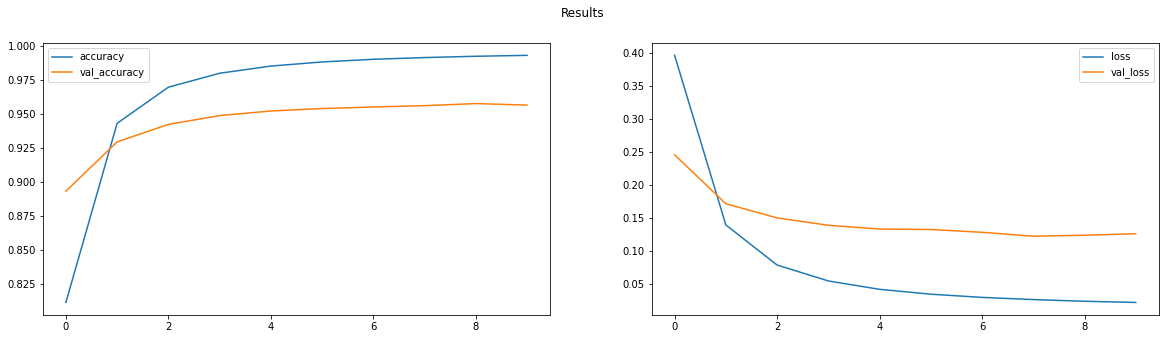

In [ ]:
results = pd.DataFrame(history.history)

#Split the count plot.
f, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(20,5))
plt.suptitle('Results')
results[['accuracy', 'val_accuracy']].plot(ax=ax1)
results[['loss', 'val_loss']].plot(ax=ax2)
plt.show()

In [ ]:
#Fix this to binary class identification. Re-reun classificationo report. 
from sklearn.metrics import classification_report

#predicted_class_indices=np.argmax(pred,axis=-1) 
predicted_class_indices=(pred > 0.5).astype("int32") #binary class identification.
y_true = test.target

print(classification_report(y_true, 
                            predicted_class_indices))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97   2783293
           1       0.92      0.93      0.92   1132848

    accuracy                           0.96   3916141
   macro avg       0.95      0.95      0.95   3916141
weighted avg       0.96      0.96      0.96   3916141



In [ ]:
# Save the model; in case I need to re-predict everything. 
model.save('/content/drive/MyDrive/Thinkful/Data/gender_predictor.h5')

In [ ]:
data = test.copy()
data['pred_gender'] = predicted_class_indices
data[data.target != data.pred_gender]

,timestamp,longitude,latitude,is_active,phone_brand,device_model,category,target,pred_gender
4181528,1462638793000000000,0.00,0.00,1.0,华为,荣耀6,Industry tag,1,0
5781197,1462437418000000000,121.88,41.13,0.0,小米,MI 4,Cozy 1,1,0
1545531,1462386842000000000,113.99,23.06,1.0,华为,荣耀6,Property Industry 1.0,1,0
900344,1462558317000000000,0.00,0.00,1.0,小米,小米4C,Industry tag,0,1
5202373,1462487383000000000,0.00,0.00,1.0,华为,Mate 7,Industry tag,1,0
...,...,...,...,...,...,...,...,...,...
581560,1462109834000000000,116.37,35.28,1.0,小米,红米Note2,unknown,1,0
6406919,1462551237000000000,0.00,0.00,0.0,魅族,MX2,unknown,0,1
4131637,1462478383000000000,0.00,0.00,0.0,三星,Galaxy Core Max,Finance,0,1
6458118,1462465110000000000,0.00,0.00,0.0,小米,MI 2A,1 free,1,0


In [ ]:
#I don't know which is better; to predict on the saved prediction model or to call everything from a zip file. The zip file is good for coding and testing.
# Saving and recalling/relearning on the model is better for new data. I'm exporting to zip for now in the interest of saving time, but for the purpose of a product; it may be better
#to work from the prediction model.
data.to_csv('/content/drive/MyDrive/Thinkful/Data/gender.csv', compression='zip')

# Deep Learning - Group Classification 

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Thinkful/Data/gender.csv', compression='zip', index_col=0)

In [176]:
data.target = talkdata['group']

## improper fitting

*for learning purposes, this model was originally fit without standard encoding techniques. I have kept this around in case anyone wants a look at the difference.*

In [177]:
# Number of components
k = 5000
#Number of samples
n = 1000000
#Take a sample of the data.
sample = data.sample(n=n)

#Ordinal encode and translate to categorical.
oec = OrdinalEncoder()
y = oec.fit_transform(sample['target'].values.reshape(-1,1))

#Assign the target variable.
X = sample.drop(columns=['target'])

#One hot encode.
enc = OneHotEncoder()
X_enc = enc.fit_transform(X, y)

#Tranfrom the components.
skb = SelectKBest(k=k)
X_skb = skb.fit_transform(X_enc, y.ravel())

#Convert target to categorical
y = tf.keras.utils.to_categorical(y)

#split the data.
X_train, X_test, y_train, y_test = train_test_split(X_skb, y, test_size=0.2)
print(f'Shape of training: {X_train.shape} {y_train.shape} \n Shape of Test: {X_test.shape}, {y_test.shape}')

Shape of training: (800000, 5000) (800000, 12) 
 Shape of Test: (200000, 5000), (200000, 12)


In [178]:
model = Sequential()

model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))



In [179]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64)

Epoch 1/10
12500/12500 [==============================] - 43s 3ms/step - loss: 1.0902 - accuracy: 0.6236 - val_loss: 0.6710 - val_accuracy: 0.7662
Epoch 2/10
12500/12500 [==============================] - 42s 3ms/step - loss: 0.6277 - accuracy: 0.7749 - val_loss: 0.6041 - val_accuracy: 0.7840
Epoch 3/10
12500/12500 [==============================] - 41s 3ms/step - loss: 0.5651 - accuracy: 0.7929 - val_loss: 0.5810 - val_accuracy: 0.7903
Epoch 4/10
12500/12500 [==============================] - 41s 3ms/step - loss: 0.5385 - accuracy: 0.8008 - val_loss: 0.5690 - val_accuracy: 0.7932
Epoch 5/10
12500/12500 [==============================] - 42s 3ms/step - loss: 0.5278 - accuracy: 0.8030 - val_loss: 0.5616 - val_accuracy: 0.7978
Epoch 6/10
12500/12500 [==============================] - 40s 3ms/step - loss: 0.5210 - accuracy: 0.8051 - val_loss: 0.5587 - val_accuracy: 0.7970
Epoch 7/10
12500/12500 [==============================] - 42s 3ms/step - loss: 0.5145 - accuracy: 0.8064 - val_loss: 0

In [180]:
#Fix this to binary class identification. Re-reun classificationo report. 
from sklearn.metrics import classification_report
pred = model.predict(X_test)
predicted_class_indices=np.argmax(pred,axis=-1) 
#predicted_class_indices=(pred > 0.5).astype("int32") #binary class identification.
y_true = [np.argmax(n) for n in y_test]
print(classification_report(y_true, 
                            predicted_class_indices))

              precision    recall  f1-score   support

           0       0.78      0.77      0.77      7333
           1       0.87      0.72      0.79      7646
           2       0.88      0.75      0.81      6816
           3       0.78      0.74      0.76      9488
           4       0.75      0.82      0.78     14528
           5       0.76      0.83      0.79     12408
           6       0.82      0.75      0.78     12178
           7       0.85      0.77      0.81     22390
           8       0.92      0.74      0.82     14698
           9       0.86      0.79      0.82     23111
          10       0.81      0.82      0.81     34426
          11       0.73      0.89      0.80     34978

    accuracy                           0.80    200000
   macro avg       0.82      0.78      0.80    200000
weighted avg       0.81      0.80      0.80    200000



# Proper Fitting

In [195]:
# Number of components
k = 10000

#For sampling
#n = 1000000
#Take a sample of the data.
#sample = data.sample(n=n)

#for working with all data.
sample = data.copy()

In [196]:
y = sample['target']

#Assign the target variable.
X = sample.drop(columns=['target'])

In [198]:
#split the data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(f'Shape of training: {X_train.shape} {y_train.shape}')
print(f'Shape of validation: {X_val.shape} {y_val.shape}')
print(f'Shape of Test: {X_test.shape}, {y_test.shape}')

Shape of training: (2506329, 8) (2506329,)
Shape of validation: (626583, 8) (626583,)
Shape of Test: (783229, 8), (783229,)


In [199]:
#Ordinal encode and translate to categorical.
oec = OrdinalEncoder()
y_train = oec.fit_transform(y_train.values.reshape(-1,1))
y_test = oec.transform(y_test.values.reshape(-1,1))
y_val = oec.transform(y_val.values.reshape(-1,1))

In [200]:
#One hot encode.
enc = OneHotEncoder(handle_unknown='ignore')
X_train = enc.fit_transform(X_train, y_train)
X_test = enc.transform(X_test)
X_val = enc.transform(X_val)

#Tranfrom the components.
skb = SelectKBest(k=k)
X_train = skb.fit_transform(X_train, y_train.ravel())
X_test = skb.transform(X_test)
X_val = skb.transform(X_val)

#Convert target to categorical
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
y_val = tf.keras.utils.to_categorical(y_val)

In [201]:
model = Sequential()

model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

In [202]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=64)

Epoch 1/10
39162/39162 [==============================] - 128s 3ms/step - loss: 0.8537 - accuracy: 0.7049 - val_loss: 0.5523 - val_accuracy: 0.7977
Epoch 2/10
39162/39162 [==============================] - 128s 3ms/step - loss: 0.5326 - accuracy: 0.8034 - val_loss: 0.5266 - val_accuracy: 0.8048
Epoch 3/10
39162/39162 [==============================] - 128s 3ms/step - loss: 0.5115 - accuracy: 0.8092 - val_loss: 0.5176 - val_accuracy: 0.8079
Epoch 4/10
39162/39162 [==============================] - 128s 3ms/step - loss: 0.5036 - accuracy: 0.8116 - val_loss: 0.5131 - val_accuracy: 0.8082
Epoch 5/10
39162/39162 [==============================] - 129s 3ms/step - loss: 0.4996 - accuracy: 0.8126 - val_loss: 0.5104 - val_accuracy: 0.8095
Epoch 6/10
39162/39162 [==============================] - 132s 3ms/step - loss: 0.4957 - accuracy: 0.8136 - val_loss: 0.5072 - val_accuracy: 0.8108
Epoch 7/10
39162/39162 [==============================] - 131s 3ms/step - loss: 0.4936 - accuracy: 0.8143 - val_

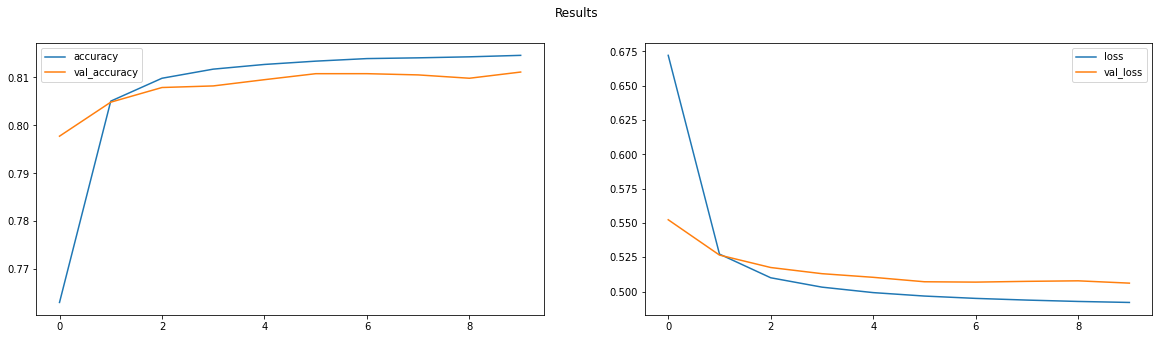

In [203]:
results = pd.DataFrame(history.history)

#Split the count plot.
f, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(20,5))
plt.suptitle('Results')
results[['accuracy', 'val_accuracy']].plot(ax=ax1)
results[['loss', 'val_loss']].plot(ax=ax2)
plt.show()

In [204]:
# get the predictions against the test dataset as whole numbers.
pred = model.predict(X_test)
predicted_class_indices=np.argmax(pred,axis=-1) 
# revert the categorical data into ordinal data. 
y_true = [np.argmax(n) for n in y_test]


print(classification_report(y_true, 
                            predicted_class_indices))

              precision    recall  f1-score   support

           0       0.82      0.77      0.80     28161
           1       0.92      0.73      0.81     29417
           2       0.91      0.77      0.83     26615
           3       0.80      0.76      0.78     36980
           4       0.71      0.88      0.78     56840
           5       0.83      0.82      0.83     48314
           6       0.90      0.73      0.81     47924
           7       0.80      0.81      0.80     89106
           8       0.93      0.74      0.83     57048
           9       0.89      0.80      0.84     90571
          10       0.81      0.83      0.82    136368
          11       0.73      0.89      0.80    135885

    accuracy                           0.81    783229
   macro avg       0.84      0.79      0.81    783229
weighted avg       0.82      0.81      0.81    783229



# Model Enhancing

In [206]:
# Number of components
k = 'all'

#For sampling
#n = 1000000
#Take a sample of the data.
#sample = data.sample(n=n)

#for working with all data.
sample = data.copy()

In [207]:
y = sample['target']

#Assign the target variable.
X = sample.drop(columns=['target'])

In [208]:
#split the data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(f'Shape of training: {X_train.shape} {y_train.shape}')
print(f'Shape of validation: {X_val.shape} {y_val.shape}')
print(f'Shape of Test: {X_test.shape}, {y_test.shape}')

Shape of training: (2506329, 8) (2506329,)
Shape of validation: (626583, 8) (626583,)
Shape of Test: (783229, 8), (783229,)


In [209]:
#Ordinal encode and translate to categorical.
oec = OrdinalEncoder()
y_train = oec.fit_transform(y_train.values.reshape(-1,1))
y_test = oec.transform(y_test.values.reshape(-1,1))
y_val = oec.transform(y_val.values.reshape(-1,1))

In [210]:
#One hot encode.
enc = OneHotEncoder(handle_unknown='ignore')
X_train = enc.fit_transform(X_train, y_train)
X_test = enc.transform(X_test)
X_val = enc.transform(X_val)

#Tranfrom the components.
skb = SelectKBest(k=k)
X_train = skb.fit_transform(X_train, y_train.ravel())
X_test = skb.transform(X_test)
X_val = skb.transform(X_val)

#Convert target to categorical
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
y_val = tf.keras.utils.to_categorical(y_val)

In [211]:
model = Sequential()

model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

In [212]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=64)

Epoch 1/10
39162/39162 [==============================] - 316s 8ms/step - loss: 0.7428 - accuracy: 0.7556 - val_loss: 0.2361 - val_accuracy: 0.9300
Epoch 2/10
39162/39162 [==============================] - 317s 8ms/step - loss: 0.1124 - accuracy: 0.9674 - val_loss: 0.1881 - val_accuracy: 0.9473
Epoch 3/10
39162/39162 [==============================] - 316s 8ms/step - loss: 0.0541 - accuracy: 0.9846 - val_loss: 0.1779 - val_accuracy: 0.9537
Epoch 4/10
39162/39162 [==============================] - 317s 8ms/step - loss: 0.0317 - accuracy: 0.9911 - val_loss: 0.1758 - val_accuracy: 0.9580
Epoch 5/10
39162/39162 [==============================] - 317s 8ms/step - loss: 0.0213 - accuracy: 0.9941 - val_loss: 0.1854 - val_accuracy: 0.9595
Epoch 6/10
39162/39162 [==============================] - 317s 8ms/step - loss: 0.0153 - accuracy: 0.9958 - val_loss: 0.1928 - val_accuracy: 0.9605
Epoch 7/10
39162/39162 [==============================] - 317s 8ms/step - loss: 0.0117 - accuracy: 0.9968 - val_

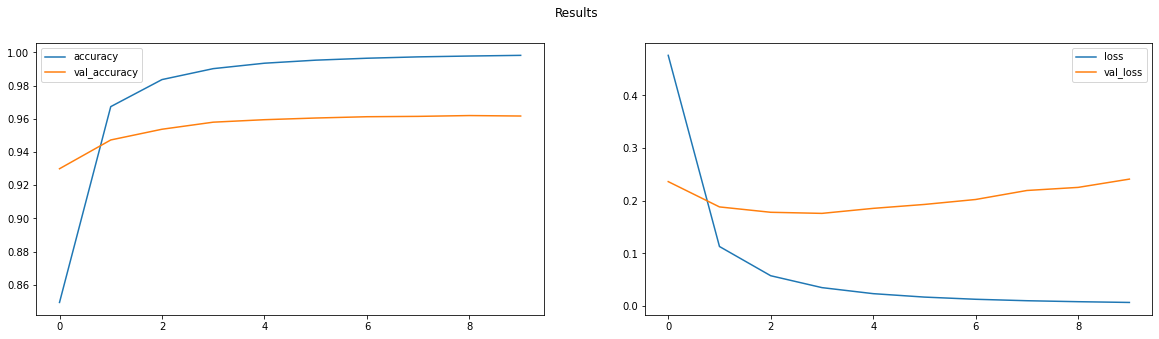

In [213]:
results = pd.DataFrame(history.history)

#Split the count plot.
f, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(20,5))
plt.suptitle('Results')
results[['accuracy', 'val_accuracy']].plot(ax=ax1)
results[['loss', 'val_loss']].plot(ax=ax2)
plt.show()

In [214]:
# get the predictions against the test dataset as whole numbers.
pred = model.predict(X_test)
predicted_class_indices=np.argmax(pred,axis=-1) 
# revert the categorical data into ordinal data. 
y_true = [np.argmax(n) for n in y_test]


print(classification_report(y_true, 
                            predicted_class_indices))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96     28451
           1       0.97      0.95      0.96     29491
           2       0.97      0.95      0.96     26489
           3       0.94      0.96      0.95     36840
           4       0.98      0.95      0.96     57252
           5       0.96      0.96      0.96     48536
           6       0.97      0.96      0.96     47832
           7       0.93      0.97      0.95     88963
           8       0.97      0.96      0.97     57089
           9       0.96      0.96      0.96     90568
          10       0.97      0.96      0.97    135882
          11       0.96      0.97      0.97    135836

    accuracy                           0.96    783229
   macro avg       0.96      0.96      0.96    783229
weighted avg       0.96      0.96      0.96    783229

